In [1]:
#Imports
import xarray as xr
import sys
sys.path.append('/home/563/rl5183/old_vdi_home/Functions')
import model_functions as func
import os
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import iris
import iris.analysis.stats as istats
from importlib import reload
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
func=reload(func)

### Model Data

In [3]:
#Read in historical model data
hist_temp = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/ts/gr1.5/')
hist_precip = func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/pr/gr1.5/')

GISS-E2-2-G path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
HadGEM3-GC31-MM path does not exist
HadGEM3-GC31-LL path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
EC-Earth3-LR path does not exist
NorESM1-F path does not exist
IITM-ESM path does not exist
45 model paths found and stored in models dictionary
Model E3SM-1-0 has weird time
GISS-E2-2-G path does not exist
KIOST-ESM path does not exist
MIROC-ES2L path does not exist
HadGEM3-GC31-MM path does not exist
HadGEM3-GC31-LL path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
EC-Earth3-LR path does not exist
NorESM1-F path does not exist
IITM-ESM path does not exist
45 model paths found and stored in models dictionary


In [4]:
#Read in future model data
future_temp = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/ts/gr1.5/')
future_precip = func.read_future_models('/g/data/lp01/CMIP6/ScenarioMIP/', '/ssp585/r1i1p1f1/Amon/pr/gr1.5/')

MPI-ESM-1-2-HAM path does not exist
MCM-UA-1-0 path does not exist
MIROC-ES2L path does not exist
FIO-ESM-2-0 path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
29 model paths found and stored in models dictionary
Model FGOALS-g3 has weird time
Model MRI-ESM2-0 has weird time
Model CAMS-CSM1-0 has weird time
MPI-ESM-1-2-HAM path does not exist
MCM-UA-1-0 path does not exist
KIOST-ESM path does not exist
MIROC-ES2L path does not exist
UKESM1-0-LL path does not exist
CNRM-ESM2-1 path does not exist
CNRM-CM6-1 path does not exist
29 model paths found and stored in models dictionary
Model FGOALS-g3 has weird time
Model MRI-ESM2-0 has weird time
Model NorESM2-LM has weird time
Model CAMS-CSM1-0 has weird time


In [5]:
#Find common models between all four datasets
hist_temp = hist_temp.where(hist_temp.model.isin(hist_precip.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_temp.model), drop = True)
hist_temp = hist_temp.where(hist_temp.model.isin(future_precip.model), drop = True)
hist_precip = hist_precip.where(hist_precip.model.isin(hist_temp.model), drop = True)
future_temp = future_temp.where(future_temp.model.isin(hist_temp.model), drop = True)
future_precip = future_precip.where(future_precip.model.isin(hist_temp.model), drop = True)

In [6]:
#discard models rejected by model evaluation
future_temp = future_temp.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_temp = hist_temp.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
future_precip = future_precip.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])
hist_precip = hist_precip.drop_sel(model=['INM-CM4-8', 'INM-CM5-0', 'TaiESM1', 'MPI-ESM1-2-HR', 'EC-Earth3-Veg', 'CIESM'])

In [7]:
#Detrend historical temperature data
hist_ts_data = hist_temp.ts

hist_ts_dt = np.apply_along_axis(scipy.signal.detrend, 1, hist_ts_data)

hist_ts = xr.DataArray(hist_ts_dt, coords=hist_ts_data.coords, attrs=hist_ts_data.attrs)

In [8]:
#Detrend future temperature data
future_ts_data = future_temp.ts

future_ts_dt = np.apply_along_axis(scipy.signal.detrend, 1, future_ts_data)

future_ts = xr.DataArray(future_ts_dt, coords=future_ts_data.coords, attrs=future_ts_data.attrs)

In [9]:
#select out precip
hist_pr = hist_precip.pr
future_pr = future_precip.pr

In [10]:
#sort models alphabetically
future_ts = future_ts.sortby('model')
hist_ts = hist_ts.sortby('model')
future_pr = future_pr.sortby('model')
hist_pr = hist_pr.sortby('model')

In [11]:
#select out two 30 year periods for comparison 
future_temp = future_ts.sel(time=slice('2070-01', '2099-12'))
hist_temp = hist_ts.sel(time=slice('1970-01', '1999-12'))
future_pr = future_pr.sel(time=slice('2070-01','2099-12'))
hist_pr = hist_pr.sel(time=slice('1970-01','1999-12'))
#Make precip data in units of mm per day
future_pr = future_pr*86400
hist_pr = hist_pr*86400

In [12]:
#Landmask
landmask_ds = xr.open_dataset('/g/data/eg3/pfd548/gridarea/land-sea_mask/fractional_land.1.5-deg.nc')
landmask = landmask_ds.mean(dim='time')

### Nino3.4 Index

In [13]:
#Calculate Nino34 index for each model over the historical period
nino34_list_hist = []
for m in hist_temp.model:
    nino34_list_hist.append(func.nino34_clim(hist_temp.sel(model=m)))
nino34_hist = xr.concat(nino34_list_hist, dim='model')

#Calculate Nino34 index for each model over the future period
nino34_list_future = []
for m in future_temp.model:
    nino34_list_future.append(func.nino34_clim(future_temp.sel(model=m)))
nino34_future = xr.concat(nino34_list_future, dim='model')

### Future and Historical SON El Nino and La Nina Composites

In [14]:
func=reload(func)

In [15]:
#Calculate DJF precip anomaly composites for El Nino in the historical period
nino_pr_comp_hist_list = []
for m in hist_pr.model:
    nino_pr_comp_hist_list.append(func.nino_pr_comp(hist_pr.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
nino_pr_comp_hist = xr.concat(nino_pr_comp_hist_list, dim='model')
#Multi-model mean
nino_pr_comp_hist_mmm = nino_pr_comp_hist.mean(dim='model')

In [16]:
#Calculate DJF precip anomaly composites for El Nino in the future period
nino_pr_comp_future_list = []
for m in future_pr.model:
    nino_pr_comp_future_list.append(func.nino_pr_comp(future_pr.sel(model=m), nino34_future.sel(model=m), 'DJF'))
nino_pr_comp_future = xr.concat(nino_pr_comp_future_list, dim='model')
#Multi-model mean
nino_pr_comp_future_mmm = nino_pr_comp_future.mean(dim='model')

In [17]:
#Calculate DJF precip anomaly composites for La Nina in the historical period
nina_pr_comp_hist_list = []
for m in hist_pr.model:
    nina_pr_comp_hist_list.append(func.nina_pr_comp(hist_pr.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
nina_pr_comp_hist = xr.concat(nina_pr_comp_hist_list, dim='model')
#Landmask
nina_pr_comp_hist_mmm = nina_pr_comp_hist.mean(dim='model')

In [18]:
#Calculate DJF precip anomaly composites for La Nina in the future period
nina_pr_comp_future_list = []
for m in future_pr.model:
    nina_pr_comp_future_list.append(func.nina_pr_comp(future_pr.sel(model=m), nino34_future.sel(model=m), 'DJF'))
nina_pr_comp_future = xr.concat(nina_pr_comp_future_list, dim='model')
#Multi-model mean
nina_pr_comp_future_mmm = nina_pr_comp_future.mean(dim='model')

### Plot the SON El Nino and La Nina precipitation anomaly composites for each period

In [19]:
cmap_precip = mpl.colors.ListedColormap(['saddlebrown', 'sienna', 'chocolate', 'sandybrown', 'navajowhite', 'blanchedalmond', 'papayawhip', 'cornsilk', 'ivory', 'azure', 'lightcyan', 'paleturquoise', 'mediumturquoise', 'lightseagreen', 'darkcyan', 'teal', 'green', 'darkgreen'])

Text(0.5, 0, 'mm per day')

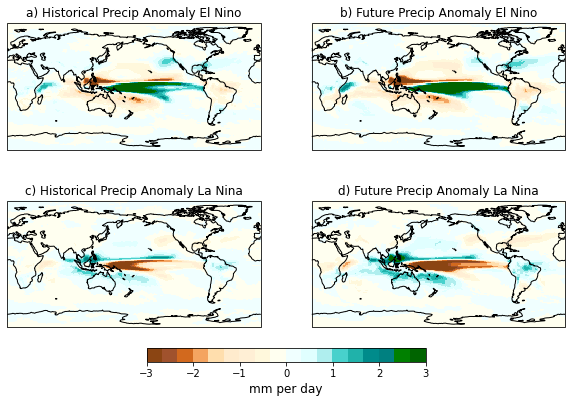

In [20]:
fig = plt.figure(figsize=(10,7.5))
axs = []

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
C = nino_pr_comp_hist_mmm.plot(ax=ax, vmin=-3, vmax=3, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('a) Historical Precip Anomaly El Nino')
axs.append(ax)

ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
C = nino_pr_comp_future_mmm.plot(ax=ax, vmin=-3, vmax=3, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('b) Future Precip Anomaly El Nino')
axs.append(ax)

ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
C = nina_pr_comp_hist_mmm.plot(ax=ax, vmin=-3, vmax=3, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('c) Historical Precip Anomaly La Nina')
axs.append(ax)

ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
C = nina_pr_comp_future_mmm.plot(ax=ax, vmin=-3, vmax=3, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('d) Future Precip Anomaly La Nina')
axs.append(ax)

cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('mm per day', fontsize=12)

#plt.savefig('precip anomalies mmm son.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

In [21]:
#Change in precip anomaly
change_in_elnino_pr = nino_pr_comp_future_mmm - nino_pr_comp_hist_mmm
change_in_lanina_pr = nina_pr_comp_future_mmm - nina_pr_comp_hist_mmm

Text(0.5, 0, 'mm per day')

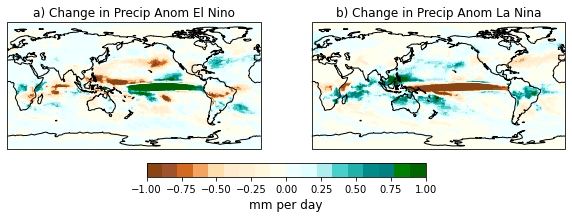

In [22]:
fig = plt.figure(figsize=(10,5))
axs = []

ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
C = change_in_elnino_pr.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('a) Change in Precip Anom El Nino')
axs.append(ax)

ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
C = change_in_lanina_pr.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('b) Change in Precip Anom La Nina')
axs.append(ax)

cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('mm per day', fontsize=12)

#plt.savefig('change in precip anomalies mmm son.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

### Zoom in over Australia 

Text(0.5, 0, 'mm per day')

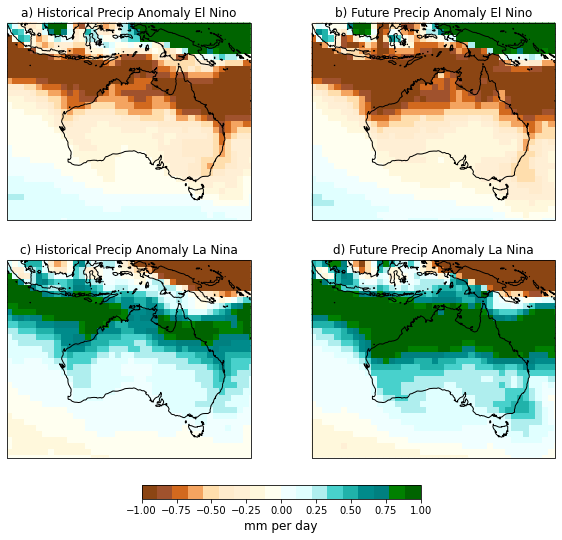

In [23]:
fig = plt.figure(figsize=(10,10))
axs = []

ax = fig.add_subplot(221, projection=ccrs.PlateCarree(180))
ax.set_extent([100, 160, -45, 0])
C = nino_pr_comp_hist_mmm.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('a) Historical Precip Anomaly El Nino')
axs.append(ax)

ax = fig.add_subplot(222, projection=ccrs.PlateCarree(180))
ax.set_extent([100, 160, -45, 0])
C = nino_pr_comp_future_mmm.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('b) Future Precip Anomaly El Nino')
axs.append(ax)

ax = fig.add_subplot(223, projection=ccrs.PlateCarree(180))
ax.set_extent([100, 160, -45, 0])
C = nina_pr_comp_hist_mmm.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('c) Historical Precip Anomaly La Nina')
axs.append(ax)

ax = fig.add_subplot(224, projection=ccrs.PlateCarree(180))
ax.set_extent([100, 160, -45, 0])
C = nina_pr_comp_future_mmm.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('d) Future Precip Anomaly La Nina')
axs.append(ax)

cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('mm per day', fontsize=12)

#plt.savefig('precip anomalies mmm son aus.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

Text(0.5, 0, 'mm per day')

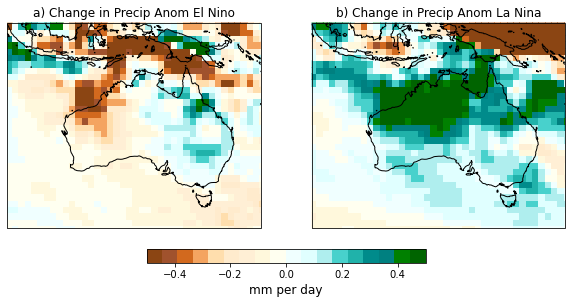

In [24]:
fig = plt.figure(figsize=(10,7.5))
axs = []

ax = fig.add_subplot(121, projection=ccrs.PlateCarree(180))
ax.set_extent([100, 160, -45, 0])
C = change_in_elnino_pr.plot(ax=ax, vmin=-0.5, vmax=0.5, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('a) Change in Precip Anom El Nino')
axs.append(ax)

ax = fig.add_subplot(122, projection=ccrs.PlateCarree(180))
ax.set_extent([100, 160, -45, 0])
C = change_in_lanina_pr.plot(ax=ax, vmin=-0.5, vmax=0.5, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('b) Change in Precip Anom La Nina')
axs.append(ax)

cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('mm per day', fontsize=12)

#plt.savefig('change in precip anomalies mmm son aus.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

### Box plot of total SON rainfall (all years), SON rainfall in El Nino and La Nina years, SON rainfall anomalies El Nino and La NIna years

In [25]:
#Total average rainfall DJF
future_pr_ea = future_pr.sel(lon = slice(140, 156)).sel(lat=slice(-44, -10))
hist_pr_ea = hist_pr.sel(lon = slice(140, 156)).sel(lat=slice(-44, -10))
#select season
total_son_pr_hist = hist_pr_ea.groupby('time.season').mean().sel(season='DJF')
total_son_pr_future = future_pr_ea.groupby('time.season').mean().sel(season='DJF')
#landmask
total_son_pr_hist_landmask = total_son_pr_hist.where(landmask.data==1)
total_son_pr_future_landmask = total_son_pr_future.where(landmask.data==1)
#average over land
total_hist_rainfall_son = total_son_pr_hist_landmask.mean(dim=['lat', 'lon'])
total_future_rainfall_son = total_son_pr_future_landmask.mean(dim=['lat', 'lon'])

In [26]:
#Total rainfall in el nino years 

nino_pr_total_hist_list = []
nino_pr_total_future_list = []

for m in hist_pr_ea.model:
    nino_pr_total_hist_list.append(func.nino_pr_comp_total(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
    nino_pr_total_future_list.append(func.nino_pr_comp_total(future_pr_ea.sel(model=m), nino34_future.sel(model=m), 'DJF'))

nino_pr_total_hist = xr.concat(nino_pr_total_hist_list, dim='model')
nino_pr_total_future = xr.concat(nino_pr_total_future_list, dim='model')

#landmask
nino_pr_total_hist_landmask = nino_pr_total_hist.where(landmask.data==1)
nino_pr_total_future_landmask = nino_pr_total_future.where(landmask.data==1)

#average over land
total_hist_rainfall_elnino = nino_pr_total_hist_landmask.mean(dim=['lat', 'lon'])
total_future_rainfall_elnino = nino_pr_total_future_landmask.mean(dim=['lat', 'lon'])

#Total rainfall in la nina years 

nina_pr_total_hist_list = []
nina_pr_total_future_list = []

for m in hist_pr_ea.model:
    nina_pr_total_hist_list.append(func.nina_pr_comp_total(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
    nina_pr_total_future_list.append(func.nina_pr_comp_total(future_pr_ea.sel(model=m), nino34_future.sel(model=m), 'DJF'))

nina_pr_total_hist = xr.concat(nina_pr_total_hist_list, dim='model')
nina_pr_total_future = xr.concat(nina_pr_total_future_list, dim='model')

#landmask
nina_pr_total_hist_landmask = nina_pr_total_hist.where(landmask.data==1)
nina_pr_total_future_landmask = nina_pr_total_future.where(landmask.data==1)

#average over land
total_hist_rainfall_lanina = nina_pr_total_hist_landmask.mean(dim=['lat', 'lon'])
total_future_rainfall_lanina = nina_pr_total_future_landmask.mean(dim=['lat', 'lon'])

In [27]:
#Total rainfall anomaly in el nino years 

nino_pr_anom_hist_list = []
nino_pr_anom_future_list = []

for m in hist_pr_ea.model:
    nino_pr_anom_hist_list.append(func.nino_pr_comp(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
    nino_pr_anom_future_list.append(func.nino_pr_comp(future_pr_ea.sel(model=m), nino34_future.sel(model=m), 'DJF'))

nino_pr_anom_hist = xr.concat(nino_pr_anom_hist_list, dim='model')
nino_pr_anom_future = xr.concat(nino_pr_anom_future_list, dim='model')

#landmask
nino_pr_anom_hist_landmask = nino_pr_anom_hist.where(landmask.data==1)
nino_pr_anom_future_landmask = nino_pr_anom_future.where(landmask.data==1)

#average over land
hist_rainfall_anom_elnino = nino_pr_anom_hist_landmask.mean(dim=['lat', 'lon'])
future_rainfall_anom_elnino = nino_pr_anom_future_landmask.mean(dim=['lat', 'lon'])

#Total rainfall anomaly in lanina years 

nina_pr_anom_hist_list = []
nina_pr_anom_future_list = []

for m in hist_pr_ea.model:
    nina_pr_anom_hist_list.append(func.nina_pr_comp(hist_pr_ea.sel(model=m), nino34_hist.sel(model=m), 'DJF'))
    nina_pr_anom_future_list.append(func.nina_pr_comp(future_pr_ea.sel(model=m), nino34_future.sel(model=m), 'DJF'))

nina_pr_anom_hist = xr.concat(nina_pr_anom_hist_list, dim='model')
nina_pr_anom_future = xr.concat(nina_pr_anom_future_list, dim='model')

#landmask
nina_pr_anom_hist_landmask = nina_pr_anom_hist.where(landmask.data==1)
nina_pr_anom_future_landmask = nina_pr_anom_future.where(landmask.data==1)

#average over land
hist_rainfall_anom_lanina = nina_pr_anom_hist_landmask.mean(dim=['lat', 'lon'])
future_rainfall_anom_lanina = nina_pr_anom_future_landmask.mean(dim=['lat', 'lon'])

In [28]:
def draw_plot(data, edge_color, fill_color, positions):
    bp = ax.boxplot(data, patch_artist=True, positions=positions, widths=0.6)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color) 

In [29]:
x1 = total_hist_rainfall_son
x2 = total_future_rainfall_son
x3 = total_hist_rainfall_elnino
x4 = total_future_rainfall_elnino
x5 = total_hist_rainfall_lanina
x6 = total_future_rainfall_lanina
x7 = hist_rainfall_anom_elnino
x8 = future_rainfall_anom_elnino
x9 = hist_rainfall_anom_lanina
x10 = future_rainfall_anom_lanina

Text(0, 0.5, 'mm per day')

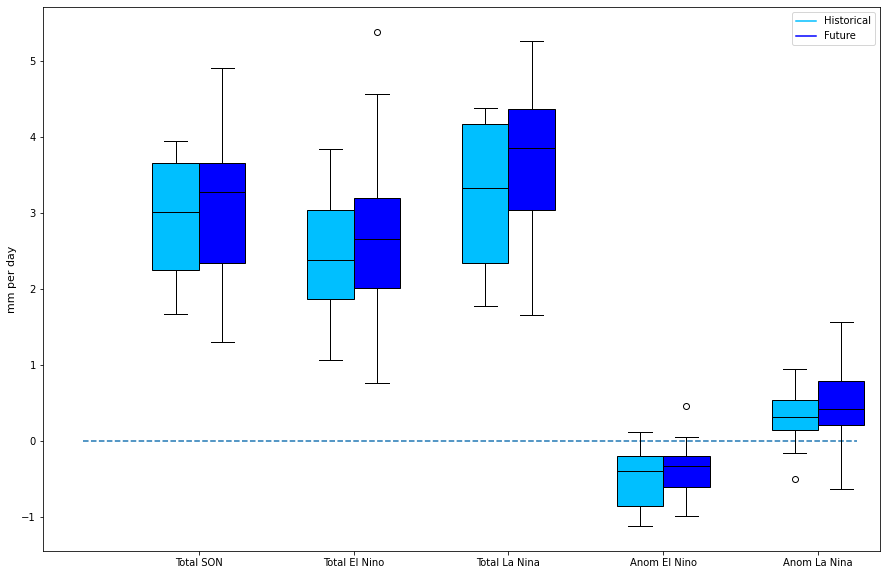

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
draw_plot([x1, x3, x5, x7, x9], 'black', 'deepskyblue', [1.2, 3.2, 5.2, 7.2, 9.2])
draw_plot([x2, x4, x6, x8, x10], 'black', 'blue', [1.8, 3.8, 5.8, 7.8, 9.8])
ax.set_xticks([1.5, 3.5, 5.5, 7.5, 9.5])
ax.set_xticklabels(['Total SON', 'Total El Nino', 'Total La Nina', 'Anom El Nino', 'Anom La Nina'])
#plot zero line
plt.hlines(0, 0, 10, linestyles='dashed')
#legend
h, = plt.plot([0,1],'deepskyblue')
f, = plt.plot([0,1],'blue')
plt.legend((h, f),('Historical', 'Future'))
h.set_visible(False)
f.set_visible(False)
#labels
plt.ylabel('mm per day', fontsize=11)
#plt.savefig('area_average_rainfall_boxplot_SON.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')

### Mean rainfall trend

In [31]:
future_pr_aus = future_pr.sel(lon = slice(112, 156)).sel(lat=slice(-44, -10))
hist_pr_aus = hist_pr.sel(lon = slice(112, 156)).sel(lat=slice(-44, -10))

In [32]:
#Mean rainfall trend all seasons
mean_rainfall_trend_all = future_pr_aus.mean(dim='time') - hist_pr_aus.mean(dim='time')
mean_rainfall_trend_mmm = mean_rainfall_trend_all.mean(dim='model')
mean_rainfall_trend_mmm = mean_rainfall_trend_mmm.where(landmask.data==1)
#Mean rainfall trend DJF
hist_rainfall_son = hist_pr_aus.groupby('time.season').mean().sel(season='DJF')
future_rainfall_son = future_pr_aus.groupby('time.season').mean().sel(season='DJF')
mean_rainfall_trend_son = future_rainfall_son - hist_rainfall_son
mean_rainfall_trend_son_mmm = mean_rainfall_trend_son.mean(dim='model')
mean_rainfall_trend_son_mmm = mean_rainfall_trend_son_mmm.where(landmask.data==1)

Text(0.5, 0, 'mm per day')

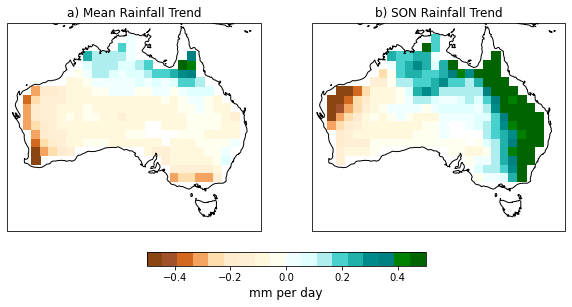

In [33]:
fig = plt.figure(figsize=(10,7.5))
axs = []

ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_extent([112, 156, -44, -10])
im = mean_rainfall_trend_mmm.plot(ax=ax, vmin=-0.3, vmax=0.3, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('a) Mean Rainfall Trend')
axs.append(ax)

ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent([112, 156, -44, -10])
im = mean_rainfall_trend_son_mmm.plot(ax=ax, vmin=-0.3, vmax=0.3, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_precip)
ax.coastlines()
ax.set_title('b) SON Rainfall Trend')
axs.append(ax)

cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_xlabel('mm per day', fontsize=12)

#plt.savefig('mean_rainfall_trends.jpg', dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')